In [1]:
import numpy as np
from sqlalchemy import create_engine
import pandas as pd
import datetime
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
engine = create_engine("sqlite:///mta.db")

In [4]:
all_tables = engine.table_names()
all_tables

<ipython-input-4-9dbbbb8bc6ba>:1: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  all_tables = engine.table_names()


['turnstile_210327',
 'turnstile_210403',
 'turnstile_210410',
 'turnstile_210417',
 'turnstile_210424',
 'turnstile_210501',
 'turnstile_210508',
 'turnstile_210515',
 'turnstile_210522',
 'turnstile_210529',
 'turnstile_210605',
 'turnstile_210612',
 'turnstile_210619',
 'turnstile_210626']

In [2]:
def get_data(week_num):
    url='http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
    defs=[]
    for week in week_num :
        file_url=url.format(week)
        defs.append(pd.read_csv(file_url))
    return pd.concat(defs)


week_num=[210327,210403,210410,210417,210424,210501,210508, 210515, 210522, 210529,210605,210612,210619,210626] 
#chosen dataset sample

Three_Months = get_data(week_num)

In [3]:
#change to timeSerises and make it in one col called [DATE_TIME]
Three_Months["DATE_TIME"] = pd.to_datetime(Three_Months.DATE+" "+Three_Months.TIME,
                                                  format="%m/%d/%Y %H:%M:%S")

In [18]:
#take out the spaces in my columns names.
Three_Months.columns = [column.strip() for column in Three_Months.columns]
Three_Months.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'DATE_TIME'],
      dtype='object')

In [4]:
# Get rid of the duplicate entry
Three_Months.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
Three_Months.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [5]:
turnstiles_daily = (Three_Months
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

In [6]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                   .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                   .apply(lambda grp: grp.shift(1)))

<ipython-input-6-97c00eda7609>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily


In [7]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

238 6641395.0
3082 1390173.0
18 4340953.0
738 18398229.0
14 1028362.0
25 1400020.0
327680 756269765.0
262152 553649999.0
262152 229572623.0
0 5309746.0
101 2651127.0
104 17275602.0
393225 7714275.0
2147432315 8421808.0
262144 33554713.0
24 2627860.0
232 4735529.0
135 8882903.0
1950 13809288.0
54 7903750.0
113 4454729.0
158 7643335.0
217 4780275.0
1534984195 0.0
4 1534984197.0
67109632 1.0
12517611 82.0
23157312 1627480738.0
687970551 19471253.0
1076 7489966.0
463 6101664.0
162 1110928.0
327 2524852.0
262150 2393328.0
262152 67112607.0
67436550 375578.0
143 4070964.0
5 58304715.0
0 2042881.0
528 2341721.0
2 33030303.0
95 5198958.0
79 1663686.0
262145 67109778.0
77 2320032.0
393362 104110933.0
175 315605508.0
852524 2830560.0
66470 17650908.0
357 4470823.0
70 30154514.0
1040213826 4086923.0
151200964 50928236.0
196847 3277233.0
87 303654987.0
73220297 1560551488.0
146668889 1123536132.0
1191142711 12133750.0
536886506 2125787.0
1441950 12919101.0
13943099 8899046.0
62 4183413.0
632 42661

In [8]:
#daily time series for each STATION, by adding up all the turnstiles in a station.
station_daily = turnstiles_daily.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()

In [9]:
#Over multiple weeks, sum total ridership for each 
#station and sort them, so you can find out the stations 
#with the highest traffic during the time you investigate
station_totals = station_daily.groupby('STATION').sum().sort_values('DAILY_ENTRIES', ascending=False).reset_index()

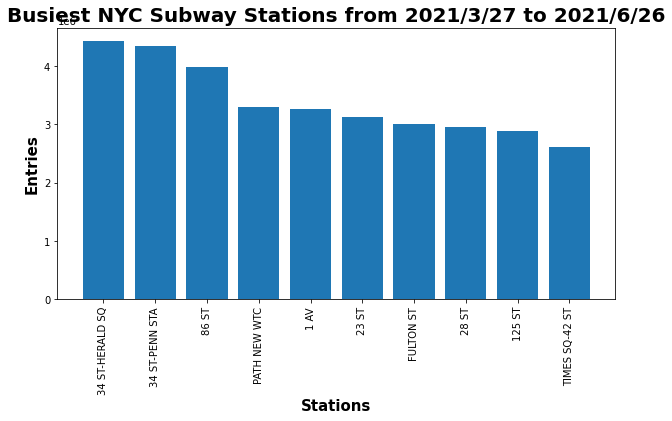

In [10]:
#Viewing top ten stations
plt.figure(figsize=(10,5))
plt.bar(x=station_totals['STATION'][:10], height=station_totals['DAILY_ENTRIES'][:10])
plt.title('Busiest NYC Subway Stations from 2021/3/27 to 2021/6/26',fontsize=20, weight='bold')
plt.xlabel('Stations', fontsize=15, weight='bold')
plt.ylabel('Entries', fontsize=15, weight='bold')
plt.xticks(rotation=90);

In [11]:
# Get rid of the duplicate exit
Three_Months.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
Three_Months.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [19]:
turnstiles__daily = (Three_Months
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .EXITS.first())

In [21]:
turnstiles__daily[["PREV_DATE", "PREV_EXITS"]] = (turnstiles__daily
                                                   .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "EXITS"]
                                                   .apply(lambda grp: grp.shift(1)))

<ipython-input-21-5cd4c839de92>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles__daily[["PREV_DATE", "PREV_EXITS"]] = (turnstiles__daily


In [22]:
def get__daily_counts(row_, max__counter):
    counter_ = row_["EXITS"] - row_["PREV_EXITS"]
    if counter_ < 0:
        # Maybe counter is reversed?
        counter_ = -counter_
    if counter_ > max__counter:
        # Maybe counter was reset to 0? 
        print(row_["EXITS"], row_["PREV_EXITS"])
        counter_ = min(row_["EXITS"], row_["PREV_EXITS"])
    if counter_ > max__counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter_

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles__daily["DAILY_EXITS"] = turnstiles__daily.apply(get__daily_counts, axis=1, max__counter=1000000)

88 8869456.0
295 7504407.0
218 1653807.0
104 436767770.0
0 469762048.0
8 763625201.0
0 3196184.0
137 2192493.0
161 1075170.0
0 1377854.0
671146416 2645604.0
66 2944229.0
68 1090165.0
1429 15269731.0
58 6427794.0
145 2774389.0
54 6592830.0
133 8070982.0
563806220 0.0
236 563806220.0
14090596 149.0
56710393 1627593327.0
1174467683 4611970.0
239 1671513.0
379 3350287.0
364 1150163.0
1073 2809308.0
278 6525554.0
14 3077761.0
3 16777216.0
189 5011886.0
0 11489500.0
0 3698310.0
0 654311429.0
131206 3684372.0
74 4035691.0
241 10121717.0
0 16777216.0
390 6668124.0
573 1332376.0
55 68794099.0
371 1508657839.0
1910 11973082.0
181 2046962.0
67 2694408.0
2013271707 7892372.0
167977315 51050462.0
304 1885911.0
240 236191254.0
17316031 134318115.0
16813981 71276.0
175519766 1980415076.0
1140892665 4482550.0
1174454286 4599885.0
440 9252156.0
6714542 2117913.0
168 10879546.0
8 1010668.0
470 1815879.0
536 11825747.0
3980632 0.0
0 3980632.0


In [23]:
#daily time series for each STATION, by adding up all the turnstiles in a station.
station__daily = turnstiles__daily.groupby(["STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()

In [24]:
#Over multiple weeks, sum total ridership for each 
#station and sort them, so you can find out the stations 
#with the highest traffic during the time you investigate
station__totals = station__daily.groupby('STATION').sum().sort_values('DAILY_EXITS', ascending=False).reset_index()

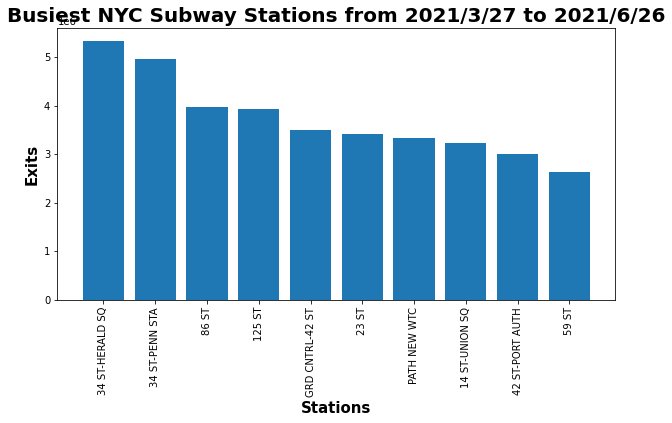

In [25]:
#Viewing top ten stations
plt.figure(figsize=(10,5))
plt.bar(x=station__totals['STATION'][:10], height=station__totals['DAILY_EXITS'][:10])
plt.title('Busiest NYC Subway Stations from 2021/3/27 to 2021/6/26',fontsize=20, weight='bold')
plt.xlabel('Stations', fontsize=15, weight='bold')
plt.ylabel('Exits', fontsize=15, weight='bold')
plt.xticks(rotation=90);